In [7]:
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt

In [8]:
cdf = pd.read_csv("gpt-4o-mini_data.csv").drop(["my_sen", "else_sen", "nice_sen", "honest_sen"], axis=1)
mdf = pd.read_csv("mistral-small_data.csv").drop(["my_sen", "else_sen", "nice_sen", "honest_sen"], axis=1)

cdf['model'] = 'gpt'
mdf['model'] = 'mistral'

pred_cols = ['my', 'else', 'nice', 'honest']

cdf[pred_cols] = (cdf[pred_cols].T - cdf["score"]).T.abs()
mdf[pred_cols] = (mdf[pred_cols].T - mdf["score"]).T.abs()
cdf = cdf.drop(columns='score')
mdf = mdf.drop(columns='score')

df_all = pd.concat([cdf, mdf], ignore_index=False)

df_long = df_all.melt(
    id_vars=["i", "model"], 
    var_name="prompt",
    value_name="llm_score"
)
df_long["prompt"] = pd.Categorical(
    df_long["prompt"],
    categories=["my", "else", "nice", "honest"],
    ordered=True
)
df_long

,i,model,prompt,llm_score
0,0,gpt,my,0
1,1,gpt,my,2
2,2,gpt,my,1
3,3,gpt,my,1
4,4,gpt,my,1
...,...,...,...,...
15995,1995,mistral,honest,0
15996,1996,mistral,honest,0
15997,1997,mistral,honest,3
15998,1998,mistral,honest,0


In [ ]:
aov = pg.rm_anova(
        data=df_long,
        dv      = "llm_score",         
        within  = ["model", "prompt"],  
        subject = "i",               
     )
aov

c:\Users\Viggo\miniconda3\envs\dtu02450\Lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
c:\Users\Viggo\miniconda3\envs\dtu02450\Lib\site-packages\pingouin\distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,model,0.05625,1,1999,0.056250,0.31657,5.737393e-01,5.737393e-01,0.000008,1.000000
1,prompt,5.58950,3,5997,1.863167,6.61869,1.845299e-04,1.548299e-03,0.000835,0.643880
2,model * prompt,6.48725,3,5997,2.162417,16.47228,1.171988e-10,1.239963e-10,0.000969,0.997082


In [10]:
print(aov[["Source","ddof1","ddof2","SS","MS","F","p-unc","p-GG-corr","eps"]].to_latex())

\begin{tabular}{llrrrrrrrr}
\toprule
 & Source & ddof1 & ddof2 & SS & MS & F & p-unc & p-GG-corr & eps \\
\midrule
0 & model & 1 & 1999 & 0.056250 & 0.056250 & 0.316570 & 0.573739 & 0.573739 & 1.000000 \\
1 & prompt & 3 & 5997 & 5.589500 & 1.863167 & 6.618690 & 0.000185 & 0.001548 & 0.643880 \\
2 & model * prompt & 3 & 5997 & 6.487250 & 2.162417 & 16.472280 & 0.000000 & 0.000000 & 0.997082 \\
\bottomrule
\end{tabular}



C:\Users\Viggo\AppData\Local\Temp\ipykernel_20048\2436236664.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot = (df_long.groupby(['model', 'prompt'])['llm_score']


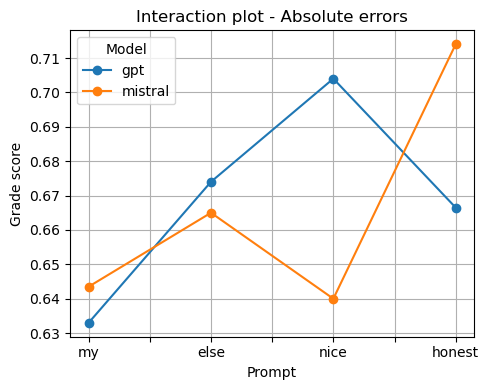

In [11]:
pivot = (df_long.groupby(['model', 'prompt'])['llm_score']
           .mean()
           .unstack('model'))       # rows = model, columns = prompt

fig, ax = plt.subplots(figsize=(5, 4))
pivot.plot(ax=ax, marker='o')

ax.set_xlabel('Prompt')
ax.set_ylabel('Grade score')
ax.set_title('Interaction plot - Absolute errors')
ax.legend(title='Model')
ax.grid(True)
plt.tight_layout()
plt.savefig("interactionerrors.pdf", format="pdf")
plt.show()

In [12]:
df_long['cond'] = df_long['model'].astype(str) + '_' + df_long['prompt'].astype(str)

posthoc = pg.pairwise_tests(data=df_long,
                             dv='llm_score',
                             within='cond',          
                             subject='i',
                             parametric=True,
                             padjust='none', # We do correction ourselves       
                             effsize='cohen')        
posthoc.round(4) # We only use the 16 relevant tests of these

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,cond,gpt_else,gpt_honest,True,True,0.6265,1999.0,two-sided,0.5310,0.031,0.0115
1,cond,gpt_else,gpt_my,True,True,2.9725,1999.0,two-sided,0.0030,2.056,0.0639
2,cond,gpt_else,gpt_nice,True,True,-1.6170,1999.0,two-sided,0.1060,0.093,-0.0462
3,cond,gpt_else,mistral_else,True,True,0.7525,1999.0,two-sided,0.4518,0.033,0.0136
4,cond,gpt_else,mistral_honest,True,True,-3.0299,1999.0,two-sided,0.0025,2.441,-0.0591
5,cond,gpt_else,mistral_my,True,True,2.0782,1999.0,two-sided,0.0378,0.217,0.0471
6,cond,gpt_else,mistral_nice,True,True,2.0173,1999.0,two-sided,0.0438,0.192,0.0530
7,cond,gpt_honest,gpt_my,True,True,2.9130,1999.0,two-sided,0.0036,1.728,0.0529
8,cond,gpt_honest,gpt_nice,True,True,-2.2585,1999.0,two-sided,0.0240,0.321,-0.0585
9,cond,gpt_honest,mistral_else,True,True,0.1327,1999.0,two-sided,0.8945,0.025,0.0023
